# Motivation
***
This notebook will discuss many different standard algorithms for implementing dimensionality reduction using the scikit-learn library.

Dimensionality reduction can be used to counteract the curse of dimensionality reduction, which is when machine learning algorithms become inefficient due to an extremely large feature space. 

Dimensionality reduction algorithms are used to project high-dimensional data to a low-dimensional space while retaining as much of the salient information as possible while removing redundant information. This enables supervised machine learning algorithms to identify interesting patterns more effectively because much of the noise will have been reduced. 

# The Data
***
We will be using the MNIST Digits database. One may acquire the pickled version [here](http://deeplearning.net/tutorial/gettingstarted.html).

This dataset is divided into a training set with 50,000 examples, a validation set with 10,000 examples and a test set with 10,000 examples. The data consist of 28x28 pixel images of handwritten digits. Each row of the data will be a flattened (28x28=784) dimensional vector. The values of the components of this vector are intensity values in the range zero to one, where zero is black and one is white. The labels are digits zero through nine. 

Standard Imports:

In [43]:
import numpy as np
import pandas as pd
import os, time
import pickle, gzip 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

Now we will load the data

In [2]:
filePath = "data/mnist.pkl.gz"
with gzip.open( filePath, 'rb' ) as file:
    train_set, validation_set, test_set = pickle.load( file, encoding='latin1' )

In [3]:
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [6]:
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of y_train: {}".format(y_train.shape))

print("Shape of X_validation: {}".format(X_validation.shape))
print("Shape of y_validation: {}".format(y_validation.shape))

print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (50000, 784)
Shape of y_train: (50000,)
Shape of X_validation: (10000, 784)
Shape of y_validation: (10000,)
Shape of X_test: (10000, 784)
Shape of y_test: (10000,)


Now we will convert these number arrays to pandas DataFrames.

We will maintain the indices as though the three sets of data are vertically concatenated as a part of the same set.

In [7]:
train_index = range( len(X_train ) )
validation_index = range( len(X_train) , len(X_train) + len(X_validation) )
test_index = range( len(X_train) + len(X_validation) , len(X_train) + len(X_validation) + len(X_test) )

X_train = pd.DataFrame( data=X_train, index=train_index )
y_train = pd.DataFrame( data=y_train, index=train_index )

X_validation = pd.DataFrame( data=X_validation, index=validation_index )
y_validation = pd.DataFrame( data=y_validation, index=validation_index )

X_test = pd.DataFrame( data=X_test, index=test_index )
y_test = pd.DataFrame( data=y_test, index=test_index )

Here is a function to help us visualize the separation of points in space. This demonstrates the power of PCA to efficiently and compactly capture the variance in the data. We display a two dimensional scatterplot of the first and second principal components and color the points by the true label.

In [8]:
def scatterPlot(xDF, yDF, algName):
    """
    This function takes in the data after being projected onto principal components, 
    and the true labels, and it plots the data points, colored according to label
    """
    # access the first two principal components
    data = pd.DataFrame(data=xDF.loc[:, 0:1], index=xDF.index)
    data = pd.concat( (data, yDF), axis=1, join="inner" )
    data.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot( x="First Vector", y="Second Vector", hue="Label", data=data, fit_reg=False )
    ax = plt.gca()
    ax.set_title("Separation of Observations using {}".format(algName))

# Principal Component Analysis
***
We will set the number of principal components to be the original number of dimensions (784). Then, we can select however many principal components we want to project the data onto.

In [9]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2019


pca = PCA( n_components=n_components, whiten=whiten, random_state=random_state )

# 50000 rows, 784 columns
X_train_PCA = pca.fit_transform( X_train )
X_train_PCA = pd.DataFrame( data=X_train_PCA, index=train_index )

Because we have not reduced the dimensionality at all (we've used the same number of principal components as there are dimensions), we would expect all of the original information to be captured by all of the principal components:

In [10]:
print("Explained variance by all 784 principal components: {}".format(np.sum(pca.explained_variance_ratio_)))

Explained variance by all 784 principal components: 1.0


We will store the explained variance ratio inside a data frame and then we will use this to visualize the explained variance as a function of the number of principal components (sorted by the explained variance of the components - so the components that are more important come first)

In [19]:
importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)
# there is one row for each of the principal components
print(importanceOfPrincipalComponents.shape)

(784, 1)


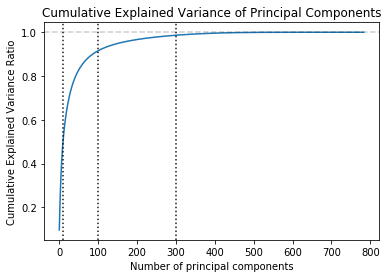

In [42]:
vertical_line_props = {'linestyle':':', 'alpha':0.9,'color':'black'}
cumulative_importance = np.cumsum(importanceOfPrincipalComponents)
plt.plot(cumulative_importance)
plt.title("Cumulative Explained Variance of Principal Components")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.axhline(1.0,color='black',linestyle='dashed',alpha=0.2)

plt.axvline(10, **vertical_line_props)
plt.axvline(100,**vertical_line_props)
plt.axvline(300,**vertical_line_props)
plt.show()

We can show that the first 10 components capture roughly 50% of the variance, the first 100 components capture over 90%, and the first three hundred components capture almost 99% of the variance in our dataset.

In [32]:
first_ten_index = 9
first_hundred_index = 99
first_three_hundred_index = 299
print("Variance captured by First 10 components: {:.2f}".format(cumulative_importance.loc[first_ten_index].values[0]))
print("Variance captured by First 100 components: {:.2f}".format(cumulative_importance.loc[first_hundred_index].values[0]))
print("Variance captured by First 300 components: {:.2f}".format(cumulative_importance.loc[first_three_hundred_index].values[0]))

Variance captured by First 10 components: 0.49
Variance captured by First 100 components: 0.91
Variance captured by First 300 components: 0.99


As one may see, we retain about 99% of the explained variance by just keeping the first 300 principal components. We could have reduced the dimensionality of our dataset by more than half and still kept a significant fraction of the information content.

Now, we will visualize the data after being projected onto the first two components:

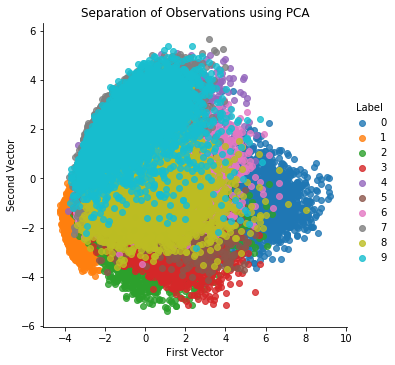

In [44]:
scatterPlot( X_train_PCA, y_train, "PCA" )

Aside from the fact that it's a nice looking visualization, we see that we do get nice clusters of data points that are determined to be similar, according to the information contained in the first two components. 

However, remember that we vastly sacrificed interpretability to get this nice visualization and reduction in dimensionality. I have no idea what it means to say that, "a given data point has a value of 2 for the first vector", in terms of the original data. It is just some linearly transformed version of the original components of the original data. 